Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
cpu


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:03<00:00, 64.9MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

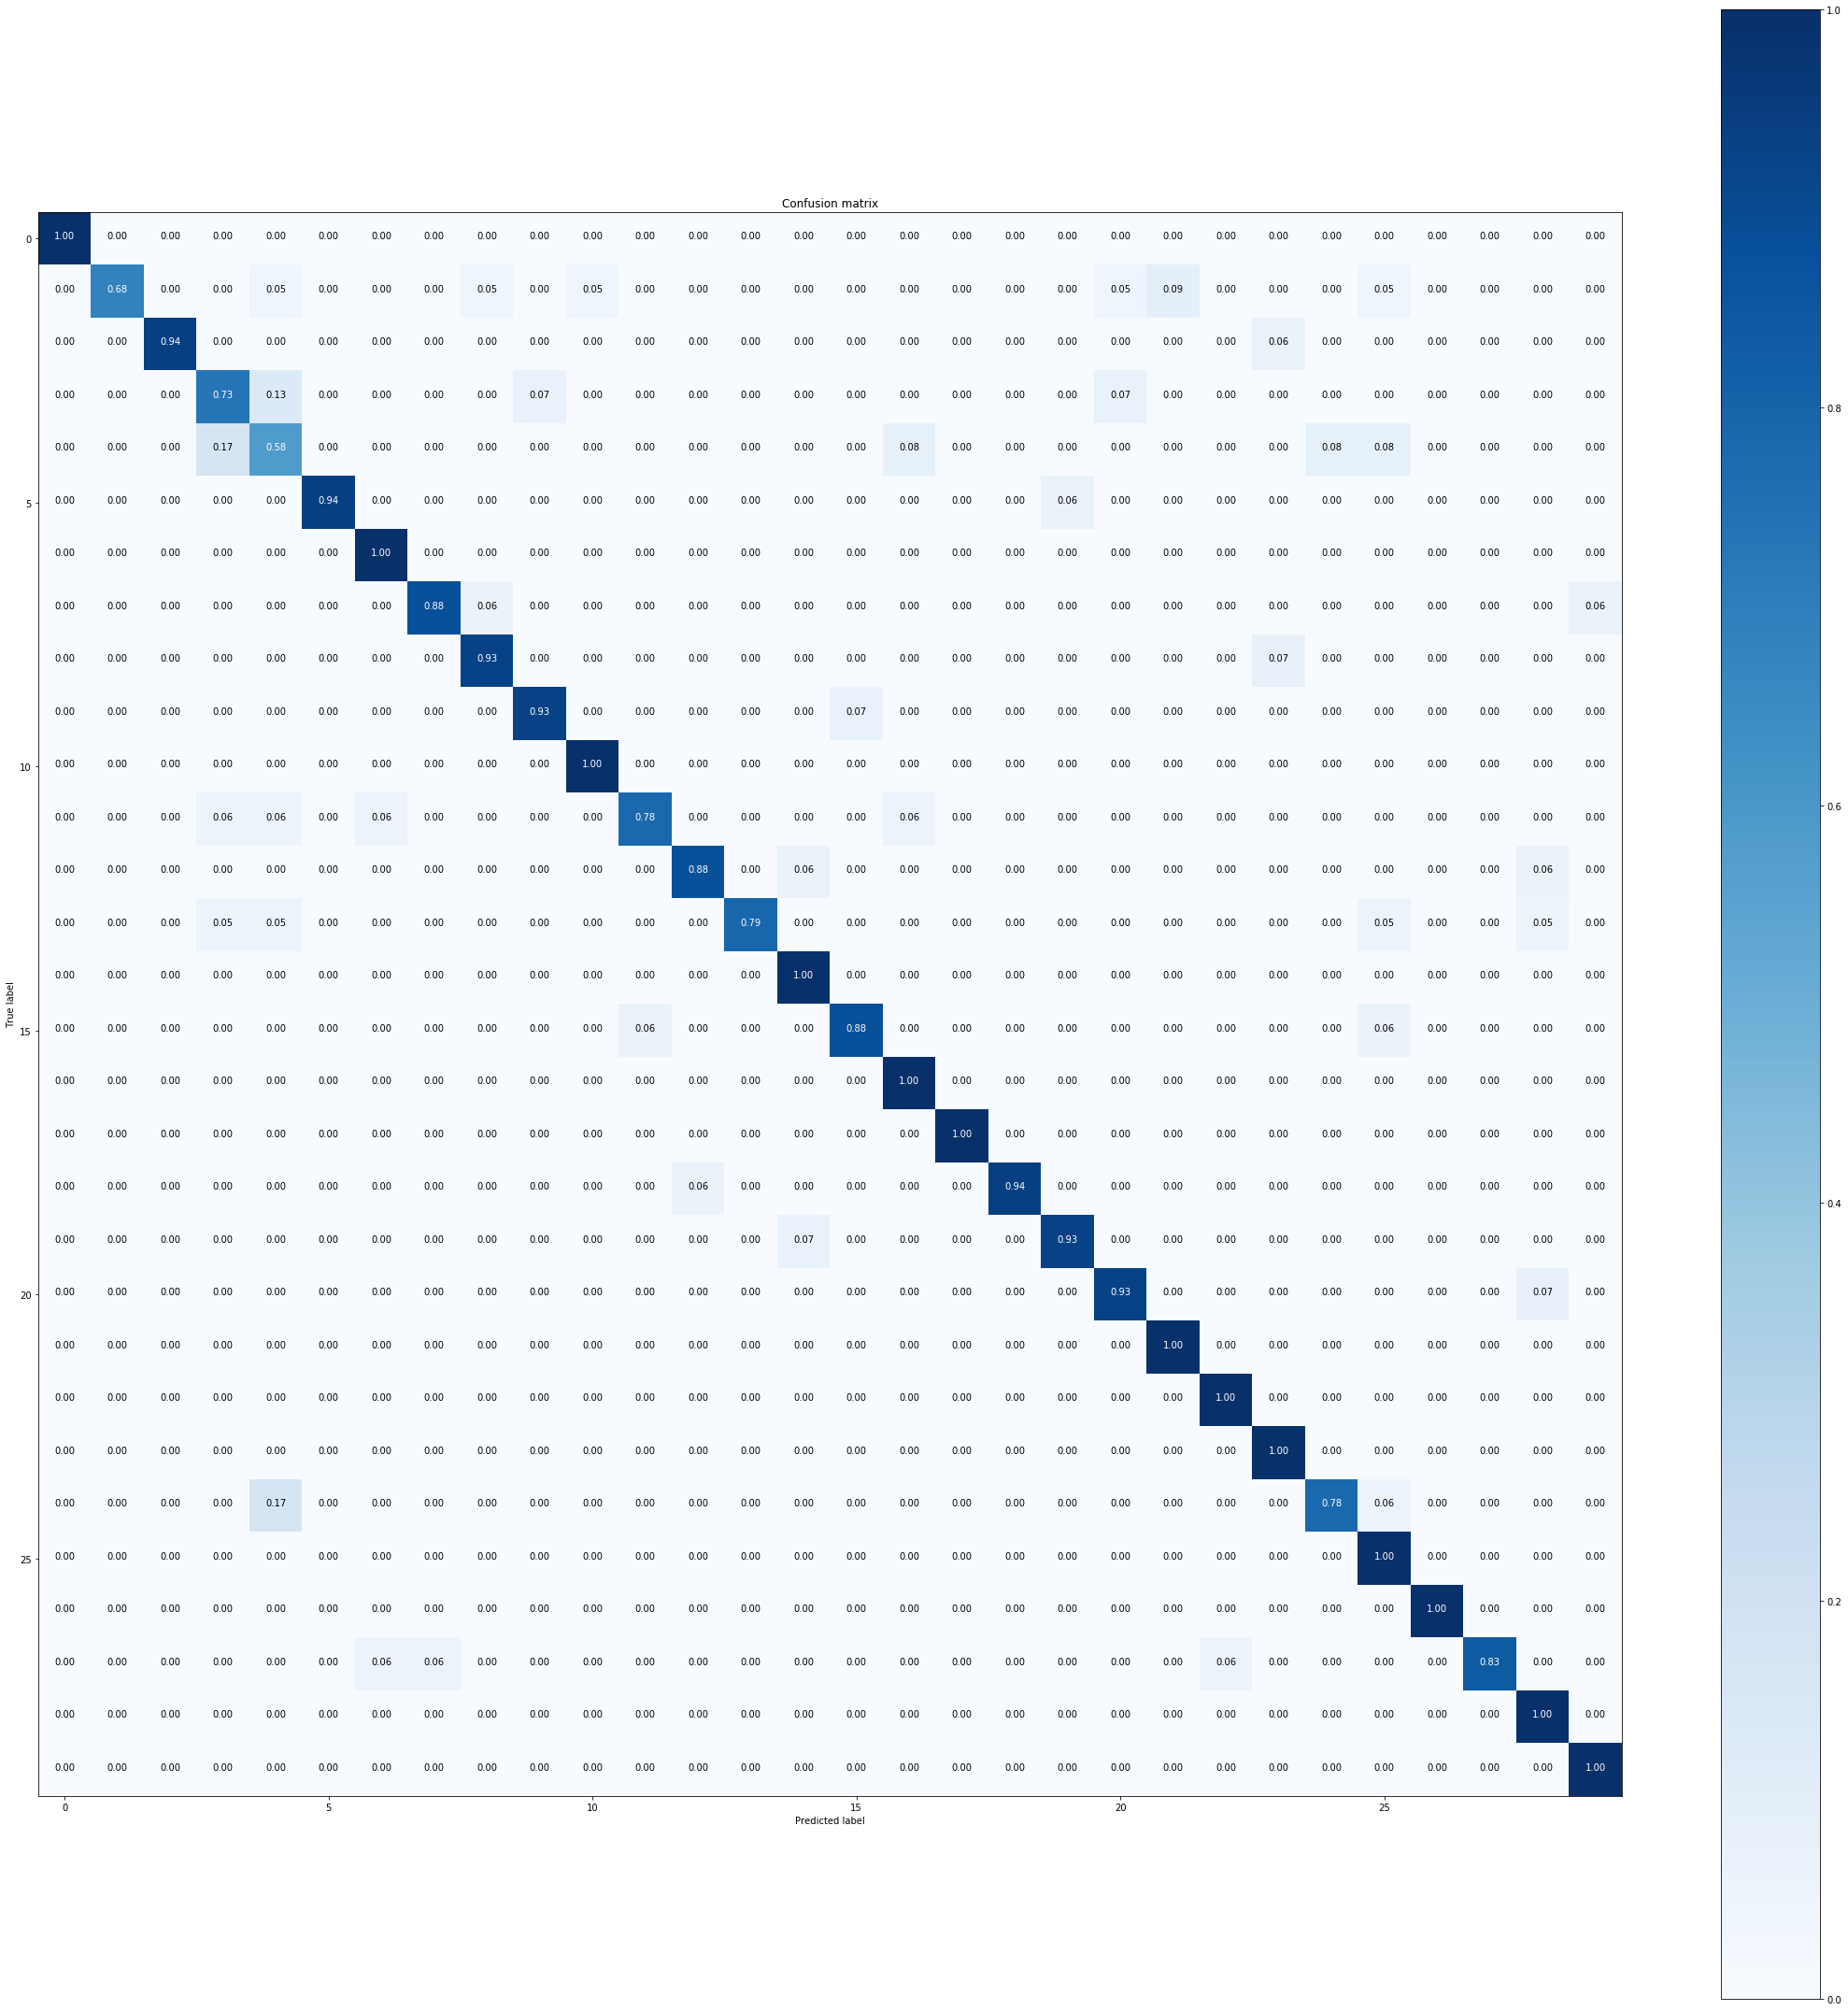

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = "/content/gdrive/My Drive/caltech101/train"
#import torchvision.models
import torchvision
from torchvision import datasets,models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
#import sys
import os
import copy
import time
#set data directory 
data_dir = "/content/drive/My Drive/caltech101/train"

# set model to alexnet
model_name='alexnet'

# Number of classes in the dataset
num_classes = 30

# Batch size for training 
batch_size = 24

# Number of epochs to train for 
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

device = torch.device("cpu")
print(device)
normalize =  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
resize = transforms . Resize ((224 , 224) )
preprocessor = transforms .Compose ([ resize , transforms . ToTensor () , normalize , ])

dataset=torchvision.datasets.ImageFolder(root_path,preprocessor)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
      for param in model.parameters():
          param.requires_grad = False
model_ft = models.alexnet(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 224
print(model_ft)
image_datasets = {x: dataset for x in ['train', 'val']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

#Larger rate for the last layer
optimizer_ft = optim.SGD([{'params': model_ft.classifier[6].parameters(), 'lr':0.01}], lr=0.001, momentum=0.9)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=10)
PATH = '/content/gdrive/My Drive/caltech101.finetune_new.pth'
torch.save(model_ft.state_dict(), PATH)
test_dir = "/content/gdrive/My Drive/caltech101/test"
testset=torchvision.datasets.ImageFolder(test_dir,preprocessor)
testloader=torch . utils . data . DataLoader( testset , batch_size=4 , shuffle=True)
test_labels = testloader.dataset.targets
print(test_labels)
correct = 0
total = 0
confusion_matrix = torch.zeros(30, 30)
labels_list=[]
predicts_list=[]
all_predicted=[]
t=0
p=0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        #for t, p in zip(labels.view(-1), predicted.view(-1)):     # line are for Confusion matrix 
        #        confusion_matrix[t.long(), p.long()] += 1         # line are for Confusion matrix
        #labels_list.append(labels)
        #predicts_list.append(predicted)
        labels_list+=labels.numpy().tolist()
        #print(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted += predicted.numpy().tolist()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
#print(labels_list)
#print(all_predicted)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(pred_class, actual_class,
                          title='Confusion matrix',
                          size=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Code from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(actual_class, pred_class)



    cmap = plt.cm.Blues
    cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    if cm is not None:
        cm = cm[0:size, 0:size]

    print('Confusion matrix')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#testloader=torch . utils . data . DataLoader( testset , batch_size=4 , shuffle=True)
#net1 = FullNet()
#net1.fit(trainloader)
pred_labels =all_predicted# p.long()#net1.predict(testloader)
plt.figure(figsize=(30,30))

print(len(labels_list),len(pred_labels))

test_labels = labels_list#t.long()#testloader.dataset.targets
plot_confusion_matrix(test_labels, pred_labels,size=len(pred_labels))
#plot_confusion_matrix(confusion_matrix,size=len(pred_labels))
